# Risk-targeted risk-parity portfolio: 

This document computes a similar diversified risk-targeted risk parity portfolio as the  [Man AHL TargetRisk](https://www.man.com/ahl-targetrisk) or [Ray Dalio's All weather portfolio](https://www.optimizedportfolio.com/all-weather-portfolio/). There are some key differences between each portfolio implementation, however, they both try to diversify, equalize the marginal risk contribution and rescale the portfolio to allow for a specific annualized risk level.  

Additional links:

https://portfolioslab.com/portfolio/ray-dalio-all-weather


https://info.recipeinvesting.com/t.pure.html



In [122]:
import yfinance as yf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import sympy as sp 
import seaborn as sns

In [100]:
def Riskparity(Sigma, b, risktarget) -> dict:
    """
    Sigma: covariance matrix, 
    b: Risk contributions. For riskparity this should 1/n for n being amount of assets in universe. 
    risktarget: Insert risktarget and rescales portfolio. For annualized value then do risktarget * sqrt(252) using the square-root rule. 
    """ 
    import cvxpy as cp
    import sympy as sp 

    w = cp.Variable(Sigma.shape[0])  #portfolio weight
    obj = 0.5 * cp.quad_form(w, Sigma) - cp.sum(cp.multiply(b, cp.log(w)))  
    #objective
    constr = [w >= 0] 
    prob = cp.Problem(cp.Minimize(obj), constr)
    prob.solve()
    # normalize weights as provided in Palomar documentation: 
    w = w/cp.sum(w)

    portrisk = cp.sqrt(cp.quad_form(w, Sigma))
    alpha = risktarget / portrisk
    w_new = w * alpha
    b_new = cp.multiply(w_new, Sigma @ w_new) / cp.quad_form(w_new, Sigma)  #solution risk budget af rescaling

    x = sp.Symbol('x')
    LC_Weight = sp.solve(np.sum(w_new.value) - x - 1, x)[0] #In order to provide leverage, we need to loan money from elsewhere (ie. from shorting or loaning from the bank). This is the Leverage cost weight. 


    out = {"w_new": w_new.value, "w": w.value, "b_new": b_new.value, "LC_weight": LC_Weight}

    return(out)

def EWMA(returns, lmb= 0.94) -> np.array:
    """ Computes the simple multivariate Exponentially Weighted Moving Average estimator.

    Args:
        returns (np.array or dataframe): array or dataframe of returns
        lambda (float): Dampening/halflife factor. 
    """

    covar = np.zeros((returns.shape[1], returns.shape[1], returns.shape[0]))


    #initiate covar using unconditional covariance: 

    covar[:,:,0] = returns.cov()

    for i in range(len(returns)-1):
        covar[:,:,i+1] = lmb * covar[:,:,i] + (1-lmb) * np.outer(returns.iloc[i,:],returns.iloc[i,:]) #returns.T @ returns

    return(covar)






In [5]:

Sigma = np.array([[6.1, 2.9, -0.8, 0.1], 
                  [2.9, 4.3, -0.3, 0.9], 
                  [-0.8, -0.3, 1.2, -0.7],
                  [0.1, 0.9, -0.7, 2.3]])
b = np.ones(4)/4  #risk parity

risktarget = 0.1


In [60]:
#under square-root rule, we want the annualized volatility to be 10%, 0.1 * sqrt(252)
ll = Riskparity(Sigma, b, 0.1 * np.sqrt(252)) #Correct. 
ll

{'w_new': array([0.32619271, 0.26863174, 1.12768609, 0.64716242]),
 'w': array([0.13765305, 0.11336237, 0.47588258, 0.273102  ]),
 'b_new': array([0.25000017, 0.24999975, 0.24999992, 0.25000017])}

In [7]:
tickers = ["SPY", "GLD", "TLT", "HYG", "TIP"] #Stocks, Gold, Longterm Treasuries, Corporate bonds (High Yield), Treasure inflation protected bonds (a bet on rising inflation).
data = []

for i in tickers: 
    stockdata = yf.download(i, start = "1997-01-01", end = "2022-04-01")[['Adj Close', 'Volume']]
    data.append(stockdata['Adj Close'])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
DF = pd.DataFrame(data).T
DF.columns = tickers
DF = DF.dropna(axis = 0)

In [41]:
DF_Returns = DF.pct_change().dropna()  * 100 #Working with linear returns for portfolio modelling. 
DF_LOGReturns = pd.DataFrame(np.diff(np.log(DF), axis =  0))  * 100 #Percentage log-returns

In [42]:
EWMALogreturns = EWMA(DF_LOGReturns)
EWMALinearreturns = EWMA(DF_Returns)

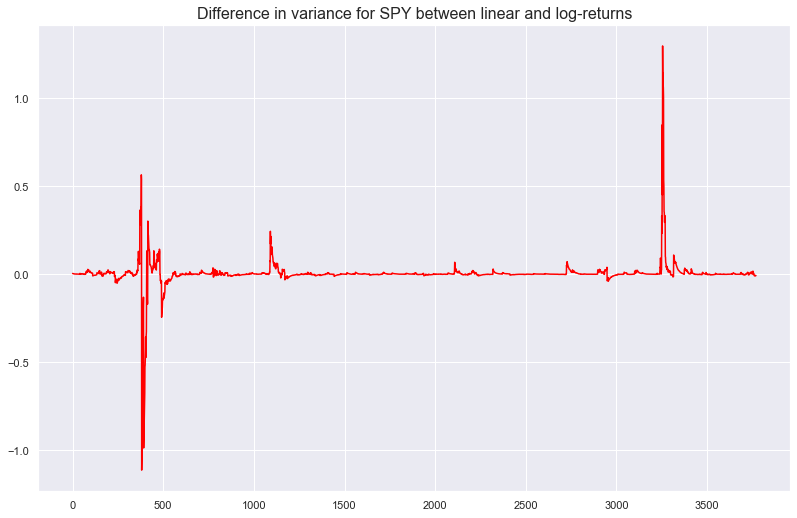

In [123]:
sns.set()
plt.figure(figsize=(12,8))
plt.plot(EWMALogreturns[0,0,:] - EWMALinearreturns[0,0,:], color = 'red')
plt.title('Difference in variance for SPY between linear and log-returns', size = 16)
plt.show()

#Makes sense since linear ret \approx 1 + log(logret). Only under 2008 and covid crisis, we observe a small difference.
#From now on we use log-returns for temporal modelling and linear returns for portfolio management. 

In [53]:
# Redefine returns under a train test split. 
# There is no reason for a train test split on the EWMA model, since we have no parameter to estimate under the train set. 
# The focus will be on the portfolio and not the modelling. Thus we will observe how the all-weather portfolio fares with a simple EWMA model in the train set. 

TrainDF, TestDF = train_test_split(DF, test_size = 0.2, shuffle = False)

TrainLogReturns = pd.DataFrame(np.diff(np.log(TrainDF), axis =  0))  * 100
TrainLinReturns = TrainDF.pct_change().dropna()  * 100 

TestLogReturns = pd.DataFrame(np.diff(np.log(TestDF), axis =  0))  * 100
TestLinReturns = TestDF.pct_change().dropna()  * 100 

In [102]:
EWMATrain = EWMA(TrainLogReturns)

Weights = np.zeros((1, 5, EWMATrain.shape[2]))
WeightsScaled = np.zeros((1, 5, EWMATrain.shape[2]))
LC_weights = np.zeros(EWMATrain.shape[2])

b = np.ones(EWMATrain.shape[0])/EWMATrain.shape[0]
for i in range(EWMATrain.shape[2]):
    temp = Riskparity(EWMATrain[:,:,i], b, 0.1 * np.sqrt(252))

    WeightsScaled[:,:,i] = temp['w_new']
    Weights[:,:,i] = temp['w']
    LC_weights[i] = temp['LC_weight']
    
#Note to self: internal sympy solver slows down computation, from 41s -> 2m10s  

c:\ProgramData\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [161]:
# first and foremost disregard leverage cost and then model everything else. 
# be aware that leveraged asset should have no volatility as it should be risk-free. --> long-term treasuries or bank account. 

# Transaction cost can simplitically be calculated by some percentage of daily turnover. 

def Turnover(w) -> np.array:
    """Calculates the daily turnover as provided in De Miguels popular paper, 'Optimal Versus Naive Diversification:
       How Inefficient is the 1/N Portfolio Strategy?'. Be aware that his presentation is a rolling turnover. 

    Args:
        w (np.array): weights including the leverage constraints

    Returns:
        np.array: the turnover of the portfolio. 
    """
    res = np.squeeze(np.abs(np.sum(w, axis = 1))) 

    return(res)

 




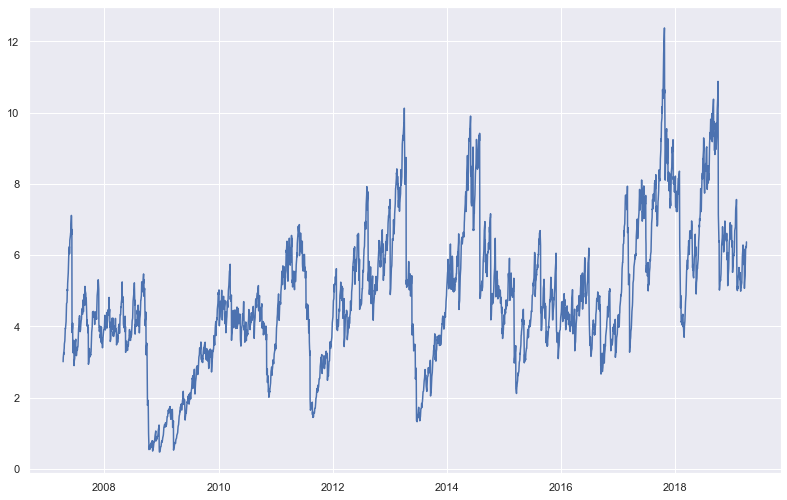

In [124]:
sns.set()
plt.figure(figsize=(12,8))
plt.plot(TrainDF.index[1:], LC_weights)
plt.title('Leverage weight over time')
plt.show()
#There is a considerable leverage in the portfolio under a 10% annualized volatility target. 

In [180]:
#tt = Turnover()

#plt.plot(tt)
#np.c_[WeightsScaled, LC_weights]

#LC_weights

np.concatenate((WeightsScaled, LC_weights), axis = 1)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 1 dimension(s)